In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41975")
client

<Client: 'tcp://127.0.0.1:41975' processes=8 threads=40, memory=157.36 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
# from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/groups/climode/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
# savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
savedir = '/tank/spectre/tuchida/NA-wavelets/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1574640+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,dd:]

array([1419120, 1421280, 1423440, 1425600, 1427760, 1429920, 1432080,
       1434240, 1436400, 1438560, 1440720, 1442880, 1445040, 1447200,
       1449360, 1451520, 1453680, 1455840, 1458000, 1460160, 1462320,
       1464480, 1466640, 1468800, 1470960, 1473120, 1475280, 1477440,
       1479600, 1481760, 1483920, 1486080, 1488240, 1490400, 1492560,
       1494720, 1496880, 1499040, 1501200, 1503360, 1505520, 1507680,
       1509840, 1512000, 1514160, 1516320, 1518480, 1520640, 1522800,
       1524960, 1527120, 1529280, 1531440, 1533600, 1535760, 1537920,
       1540080, 1542240, 1544400, 1546560, 1548720, 1550880, 1553040,
       1555200, 1557360, 1559520, 1561680, 1563840, 1566000, 1568160,
       1570320, 1572480, 1574640])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]
sreg = ['A','B','C','D','E','F']
ntheta = 36
xo = 50e3

In [7]:
dg = 1
nmembs = np.arange(100,148)


for ii in ntimes[0]:
    
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                              grid_dir=gdir,
                              prefix=['snap_diagOcn'], delta_t=2e2,
                              iters=ii, 
                             ).sel(YC=slice(15,40),YG=slice(15,40),
                                   XC=slice(290,320),XG=slice(290,320)
                                  ).isel(XG=slice(None,-1),Z=slice(None,19),Zl=slice(None,19),
                                         Zu=slice(None,19),Zp1=slice(None,20)
                                        ).chunk({'YC':100,'YG':100,
                                                 'XC':100,'XG':100,
                                                 'Z':1,'Zl':1,'Zu':1,'Zp1':1})
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                             % (nmemb)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn'], delta_t=2e2,
                                     iters=ii, 
                                    ).sel(YC=slice(15,40),YG=slice(15,40),
                                          XC=slice(290,320),XG=slice(290,320)
                                         ).isel(XG=slice(None,-1),Z=slice(None,19),Zl=slice(None,19),
                                                Zu=slice(None,19),Zp1=slice(None,20)
                                               ).chunk({'YC':100,'YG':100,
                                                        'XC':100,'XG':100,
                                                        'Z':1,'Zl':1,'Zu':1,'Zp1':1})
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                            % (nmemb)), 
                                                    grid_dir=gdir,
                                                    prefix=['snap_diagOcn'], delta_t=2e2,
                                                    iters=ii, 
                                                   ).sel(YC=slice(15,40),YG=slice(15,40),
                                                         XC=slice(290,320),XG=slice(290,320)
                                                        ).isel(XG=slice(None,-1),Z=slice(None,19),
                                                               Zl=slice(None,19),
                                                               Zu=slice(None,19),Zp1=slice(None,20)
                                                              ).chunk({'YC':100,'YG':100,
                                                                       'XC':100,'XG':100,
                                                                       'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                               ], dim='nmemb')
    ds.coords['nmemb'] = ('nmemb',nmembs)
    grid = Grid(ds, periodic=[])
    
    if ii == ntimes[0,0]:
        reg = 0
        up2 = grid.interp((ds.UVEL - dsb.UVEL)**2,
                          'X',boundary='extend'
                         ).where(ds.maskC!=0.
                                ).isel(Z=[0,18]
                                      ).sel(YC=ys[reg], method='nearest'
                                           ).sel(XC=xs[reg], method='nearest'
                                                ).reset_coords(drop=True).mean('nmemb').compute()
        vp2 = grid.interp((ds.VVEL - dsb.VVEL)**2,
                          'Y',boundary='extend'
                         ).where(ds.maskC!=0.
                                ).isel(Z=[0,18]
                                      ).sel(YC=ys[reg], method='nearest'
                                           ).sel(XC=xs[reg], method='nearest'
                                                ).reset_coords(drop=True).mean('nmemb').compute()

        EKEA = .5*(up2 + vp2)
        reg = 5
        up2 = grid.interp((ds.UVEL - dsb.UVEL)**2,
                          'X',boundary='extend'
                         ).where(ds.maskC!=0.
                                ).isel(Z=[0,18]
                                      ).sel(YC=ys[reg], method='nearest'
                                           ).sel(XC=xs[reg], method='nearest'
                                                ).reset_coords(drop=True).mean('nmemb').compute()
        vp2 = grid.interp((ds.VVEL - dsb.VVEL)**2,
                          'Y',boundary='extend'
                         ).where(ds.maskC!=0.
                                ).isel(Z=[0,18]
                                      ).sel(YC=ys[reg], method='nearest'
                                           ).sel(XC=xs[reg], method='nearest'
                                                ).reset_coords(drop=True).mean('nmemb').compute()

        EKEB = .5*(up2 + vp2)
        del up2, vp2
        print(EKEA, EKEB)
    else:
        reg = 0
        up2 = grid.interp((ds.UVEL - dsb.UVEL)**2,
                          'X',boundary='extend'
                         ).where(ds.maskC!=0.
                                ).isel(Z=[0,18]
                                      ).sel(YC=ys[reg], method='nearest'
                                           ).sel(XC=xs[reg], method='nearest'
                                                ).reset_coords(drop=True).mean('nmemb').compute()
        vp2 = grid.interp((ds.VVEL - dsb.VVEL)**2,
                          'Y',boundary='extend'
                         ).where(ds.maskC!=0.
                                ).isel(Z=[0,18]
                                      ).sel(YC=ys[reg], method='nearest'
                                           ).sel(XC=xs[reg], method='nearest'
                                                ).reset_coords(drop=True).mean('nmemb').compute()

        ekeA = .5*(up2 + vp2)
        reg = 5
        up2 = grid.interp((ds.UVEL - dsb.UVEL)**2,
                          'X',boundary='extend'
                         ).where(ds.maskC!=0.
                                ).isel(Z=[0,18]
                                      ).sel(YC=ys[reg], method='nearest'
                                           ).sel(XC=xs[reg], method='nearest'
                                                ).reset_coords(drop=True).mean('nmemb').compute()
        vp2 = grid.interp((ds.VVEL - dsb.VVEL)**2,
                          'Y',boundary='extend'
                         ).where(ds.maskC!=0.
                                ).isel(Z=[0,18]
                                      ).sel(YC=ys[reg], method='nearest'
                                           ).sel(XC=xs[reg], method='nearest'
                                                ).reset_coords(drop=True).mean('nmemb').compute()

        ekeB = .5*(up2 + vp2)
        EKEA = xr.concat([EKEA, ekeA], 'time')
        EKEB = xr.concat([EKEB, ekeB], 'time')
        
        del ekeA, ekeB, up2, vp2
        
    ds.close()
    dsb.close()

<xarray.DataArray (time: 1, Z: 2)>
array([[0.44365257, 0.13078861]], dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 3285 days
  * Z        (Z) >f4 -3.047 -452.4 <xarray.DataArray (time: 1, Z: 2)>
array([[0.00379288, 0.00108312]], dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 3285 days
  * Z        (Z) >f4 -3.047 -452.4


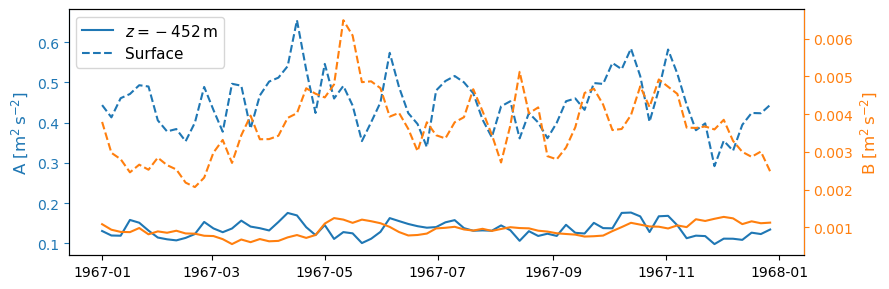

In [10]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from datetime import datetime, timedelta
time = np.arange(datetime(1967,1,1), datetime(1967,12,31), timedelta(days=5)).astype(datetime)

fig, ax = plt.subplots(figsize=(9,3))
fig.set_tight_layout(True)
ax2 = ax.twinx()
ax.plot(time, EKEA.isel(Z=1), c=colors[0], label=r"$z=-452\,$m")
ax.plot(time, EKEA.isel(Z=0), c=colors[0], ls='--', label=r"Surface")

ax2.plot(time, EKEB.isel(Z=1), c=colors[1], label=r"A")
ax2.plot(time, EKEB.isel(Z=0), c=colors[1], ls='--', label=r"B")

ax.legend(loc='upper left', fontsize=11)

# ax.set_ylim([EKEB.min(), EKEA.max()])
# ax2.set_ylim([EKEB.min(), EKEA.max()])

ax.spines['left'].set_color(colors[0])
for t in ax.yaxis.get_ticklines(): t.set_color(colors[0])
ax.yaxis.label.set_color(colors[0])
ax.tick_params(axis='y', colors=colors[0])

ax2.spines['right'].set_color(colors[1])
for t in ax2.yaxis.get_ticklines(): t.set_color(colors[1])
ax2.yaxis.label.set_color(colors[1])
ax2.tick_params(axis='y', colors=colors[1])

ax.set_ylabel(r"A [m$^2\,$s$^{-2}$]", fontsize=12)
ax2.set_ylabel(r"B [m$^2\,$s$^{-2}$]", fontsize=12)
# ax.grid(True)

plt.savefig(op.join(savedir, 'Figs/EKE_AB.pdf'))

In [11]:
dsave = EKEA.to_dataset(name='A')
dsave['B'] = EKEB
dsave.to_netcdf(op.join(savedir,'EKE_AB_timeseries.nc'))